# CO2 and temperature

*You are seeing the
notebook output generated by
[Literate.jl](https://github.com/fredrikekre/Literate.jl) from the
[Julia source file](https://github.com/JuliaGaussianProcesses/Stheno.jl/blob/master/examples/extended_mauna_loa/script.jl).
The rendered HTML can be viewed [in the docs](https://juliagaussianprocesses.github.io/KernelFunctions.jl/dev/examples/extended_mauna_loa/).*

In [1]:
using AbstractGPs
using AbstractGPsMakie
using CairoMakie
using CSV
using DataDeps
using DataFrames
using Dates
using Distributions
using KernelFunctions
using LinearAlgebra
using Optim
using ParameterHandling
using Random
using Statistics
using Stheno
using Zygote

using CairoMakie: RGB

ENV["DATADEPS_ALWAYS_ACCEPT"] = "true"

"true"

## Obtain the data

Use DataDeps.jl to obtain the data.

In [2]:
register(DataDep(
    "mauna_loa",
    "The classic Mauna Loa CO2 data.",
    "https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/monthly/" *
        "monthly_in_situ_co2_mlo.csv",
))
register(DataDep(
    "hadcrut5_global",
    "Globally-averaged surface temperatures",
    "https://www.metoffice.gov.uk/hadobs/hadcrut5/data/current/analysis/diagnostics/" *
        "HadCRUT.5.0.1.0.analysis.summary_series.global.monthly.csv",
))

┌ Warning: Over-writing registration of the datadep
│   name = "mauna_loa"
└ @ DataDeps ~/.julia/packages/DataDeps/ooWXe/src/registration.jl:15
┌ Warning: Over-writing registration of the datadep
│   name = "hadcrut5_global"
└ @ DataDeps ~/.julia/packages/DataDeps/ooWXe/src/registration.jl:15


DataDeps.DataDep{Nothing, String, typeof(DataDeps.fetch_default), typeof(identity)}("hadcrut5_global", "https://www.metoffice.gov.uk/hadobs/hadcrut5/data/current/analysis/diagnostics/HadCRUT.5.0.1.0.analysis.summary_series.global.monthly.csv", nothing, DataDeps.fetch_default, identity, "Globally-averaged surface temperatures")

Load and pre-process the data.

In [3]:
ml_df, Ttr_df, Tte_df = let

    mauna_loa_co2 = let
        mauna_loa_data_raw = CSV.read(
            joinpath(datadep"mauna_loa", "monthly_in_situ_co2_mlo.csv"), DataFrame;
            skipto=58, header=false,
        )

        data = DataFrame(
            date=map(Date, mauna_loa_data_raw.Column1, mauna_loa_data_raw.Column2),
            CO2=map(x -> x == -99.99 ? missing : x, mauna_loa_data_raw.Column5),
        )
        data = filter(:CO2 => !ismissing, data)

        # standardise CO2 data to have unit mean.
        m = mean(data.CO2)
        σ = std(data.CO2)
        data.CO2 = Float64.(data.CO2 .- m) ./ σ

        # Convert dates into floats.
        data.float_date = map(x -> x.value, data.date .- Date(1)) ./ 365

        data
    end

    temperature = let
        hadcrut5_data_raw = CSV.read(
            joinpath(
                datadep"hadcrut5_global",
                "HadCRUT.5.0.1.0.analysis.summary_series.global.monthly.csv",
            ),
            DataFrame;
            header=1,
        )

        tmp = DataFrame(
            date=hadcrut5_data_raw[!, "Time"],
            temperature=hadcrut5_data_raw[!, "Anomaly (deg C)"],
        )

        # Convert dates into floats.
        tmp.float_date = map(x -> x.value, tmp.date .- Date(1)) ./ 365

        # Remove any data from before the first Mauna Loa data.
        time_min = minimum(mauna_loa_co2.date)
        filter(:date => date -> date >= time_min, tmp)
    end

    # Split temperature data into train and test.
    Ntr = 425
    Ttr_raw = temperature[1:Ntr, :]
    Tte_raw = temperature[(Ntr + 1):end, :]

    # Standard temperature data using training data.
    mtr = mean(Ttr_raw.temperature)
    σtr = std(Ttr_raw.temperature)
    Ttr = DataFrame(
        date=Ttr_raw.date,
        float_date=Ttr_raw.float_date,
        temperature=(Ttr_raw.temperature .- mtr) ./ σtr,
    )
    Tte = DataFrame(
        date=Tte_raw.date,
        float_date=Tte_raw.float_date,
        temperature=(Tte_raw.temperature .- mtr) ./ σtr,
    )

    mauna_loa_co2, Ttr, Tte
end;

## Build and train a model for the data

Model for CO2 and temperature as a function of time.

In [4]:
function build_gp(θ)
    return @gppp let

        # Shared trend process.
        f_trend = stretch(GP(SEKernel()), θ.λ_trend)

        # Specify model for CO2.
        f_co2_latent = θ.CO2.σ_latent * f_trend
        f_co2_wiggle = θ.CO2.σ_wiggle * stretch(GP(SEKernel()), θ.CO2.λ_wiggle)
        f_co2_period = θ.CO2.σ_period * GP(SEKernel() ∘ PeriodicTransform(θ.CO2.freq))
        f_co2 = f_co2_latent + f_co2_wiggle + f_co2_period + θ.CO2.σm * GP(ConstantKernel())

        # Specify model for temperature.
        f_T_trend = θ.T.σ_trend * f_trend
        f_T_wiggle = θ.T.σ_wiggle * stretch(GP(SEKernel()), θ.T.λ_wiggle)
        f_T = f_T_trend + f_T_wiggle + θ.T.σm * GP(ConstantKernel())
    end
end

x_co2 = ml_df.float_date;
x_T_tr = Ttr_df.float_date;
x_T_te = Tte_df.float_date;

y_co2 = ml_df.CO2;
y_T_tr = Ttr_df.temperature;
y_T_te = Tte_df.temperature;

x = BlockData(GPPPInput(:f_co2, x_co2), GPPPInput(:f_T, x_T_tr))
y = vcat(y_co2, y_T_tr)

function build_obs_cov(θ)
    σ²_CO2 = θ.CO2.σ_noise^2
    σ²_T = θ.T.σ_noise^2
    return Diagonal(vcat(fill(σ²_CO2, length(y_co2)), fill(σ²_T, length(y_T_tr))))
end

function nlml(θ)
    f = build_gp(θ)
    return -logpdf(f(x, build_obs_cov(θ)), y)
end

init_params = (
    λ_trend = positive(1e-1),
    CO2 = (
        σ_latent = positive(0.3),
        σ_wiggle = positive(0.3),
        λ_wiggle = positive(5.0),
        σ_period = positive(0.3),
        freq = fixed(1.0),
        σ_noise = positive(0.1),
        σm = positive(1.0),
    ),
    T = (
        σ_trend = positive(1.0),
        σ_wiggle = positive(1.0),
        λ_wiggle = positive(0.5),
        σ_noise = positive(0.1),
        σm = positive(1.0),
    ),
)

default_optimizer = LBFGS(;
    alphaguess=Optim.LineSearches.InitialStatic(; scaled=true),
    linesearch=Optim.LineSearches.BackTracking(),
)

function optimize_loss(loss, θ_init; optimizer=default_optimizer, maxiter=1_000)
    options = Optim.Options(; iterations=maxiter, show_trace=true)

    θ_flat_init, unflatten = ParameterHandling.value_flatten(θ_init)
    loss_packed = loss ∘ unflatten

    # https://julianlsolvers.github.io/Optim.jl/stable/#user/tipsandtricks/#avoid-repeating-computations
    function fg!(F, G, x)
        if F !== nothing && G !== nothing
            val, grad = Zygote.withgradient(loss_packed, x)
            G .= only(grad)
            return val
        elseif G !== nothing
            grad = Zygote.gradient(loss_packed, x)
            G .= only(grad)
            return nothing
        elseif F !== nothing
            return loss_packed(x)
        end
    end

    result = optimize(Optim.only_fg!(fg!), θ_flat_init, optimizer, options; inplace=false)

    return unflatten(result.minimizer), result
end

function KernelFunctions.kernelmatrix(k::ConstantKernel, x::AbstractVector)
    return fill(only(k.c), length(x), length(x))
end

function KernelFunctions.kernelmatrix(k::ConstantKernel, x::AbstractVector, y::AbstractVector)
    return fill(only(k.c), length(x), length(y))
end

θ_opt, result = optimize_loss(nlml, init_params)

Iter     Function value   Gradient norm 
     0     5.305186e+03     1.200969e+04
 * time: 0.00010418891906738281
     1     1.611997e+02     1.280906e+03
 * time: 4.851800203323364
     2    -2.136696e+01     9.068074e+02
 * time: 6.225579023361206
     3    -5.042573e+02     5.082736e+02
 * time: 7.433510065078735
     4    -1.054875e+03     5.309474e+02
 * time: 8.222511053085327
     5    -1.508918e+03     3.947592e+02
 * time: 9.549419164657593
     6    -1.621205e+03     2.915614e+02
 * time: 10.492845058441162
     7    -1.673084e+03     2.629824e+02
 * time: 11.739428043365479
     8    -1.753087e+03     1.823471e+02
 * time: 12.411298990249634
     9    -1.835088e+03     2.371628e+02
 * time: 13.092640161514282
    10    -1.859546e+03     6.715777e+01
 * time: 13.882923126220703
    11    -1.880466e+03     7.232626e+01
 * time: 15.006940126419067
    12    -1.927768e+03     8.084841e+01
 * time: 16.781620025634766
    13    -1.934421e+03     9.696347e+01
 * time: 18.0391540527

((λ_trend = 0.08100331563081177, CO2 = (σ_latent = 1.0891960996933283, σ_wiggle = 0.013591971990819648, λ_wiggle = 5.316289742729709, σ_period = 0.060234276815777275, freq = 1.0, σ_noise = 0.00727002656572483, σm = 0.0016937514974261778), T = (σ_trend = 1.6662376867328532, σ_wiggle = 0.5791563957207272, λ_wiggle = 3.633307845949236, σ_noise = 0.40367612741067543, σm = 1.191804139500965)),  * Status: success

 * Candidate solution
    Final objective value:     -1.967296e+03

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 8.79e-03 ≰ 1.0e-08

 * Work counters
    Seconds run:   124  (vs limit Inf)
    Iterations:    103
    f(x) calls:    196
    ∇f(x) calls:   103
)

## Plot the resulting model fit.

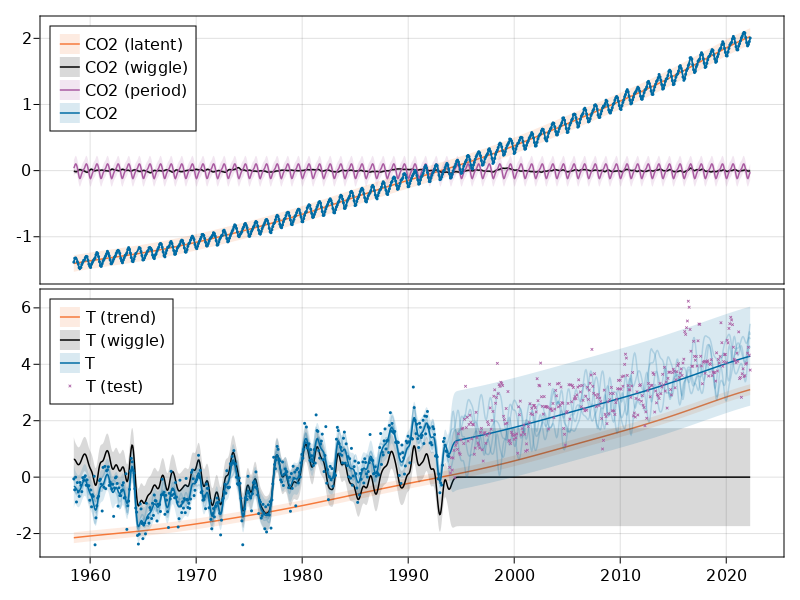

In [5]:
function colours()
    return Dict(
        :blue => RGB(0/255, 107/255, 164/255),
        :cyan => RGB(75/255, 166/255, 251/255),
        :red => RGB(200/255, 82 / 255, 0 / 255),
        :pink => RGB(169/255, 90/255, 161/255),
        :black => RGB(0.0, 0.0, 0.0),
        :orange => RGB(245/255, 121/255, 58/255),
    )
end

band_alpha() = 0.3
sample_alpha() = 0.2
point_alpha() = 1.0

x_plot = range(
    minimum(vcat(ml_df.float_date, Ttr_df.float_date)),
    maximum(vcat(ml_df.float_date, Tte_df.float_date));
    length=1_500,
);

f_post = posterior(build_gp(θ_opt)(x, build_obs_cov(θ_opt)), y);

function plot_band!(ax, x_plot, fx, colour, label)
    ms = marginals(fx)
    symband!(
        ax, x_plot, mean.(ms), std.(ms);
        bandscale=3,
        color=(colours()[colour], 0.5 * band_alpha()),
        label=label,
    )
end

function plot_sample!(ax, x_plot, fx, colour)
    gpsample!(
        ax, x_plot, fx;
        samples=4, color=(colours()[colour], sample_alpha()),
    )
end

function plot_gp!(ax, x_plot, fx, colour, label)
    plot_band!(ax, x_plot, fx, colour, label)
    plot_sample!(ax, x_plot, fx, colour)
end

let
    fig = Figure()
    ga = fig[1, 1] = GridLayout()

    jitter = 1e-6

    # Plot CO2 posterior.
    let
        ax = Axis(ga[1, 1])
        f_post_x = f_post(GPPPInput(:f_co2, x_plot), jitter)

        plot_band!(ax, x_plot, f_post(GPPPInput(:f_co2_latent, x_plot), jitter), :orange, "CO2 (latent)")
        plot_band!(ax, x_plot, f_post(GPPPInput(:f_co2_wiggle, x_plot), jitter), :black, "CO2 (wiggle)")
        plot_band!(ax, x_plot, f_post(GPPPInput(:f_co2_period, x_plot), jitter), :pink, "CO2 (period)")

        plot_gp!(ax, x_plot, f_post_x, :blue, "CO2")
        scatter!(ax, x_co2, y_co2; color=(colours()[:blue], point_alpha()), markersize=3)

        axislegend(ax; position=:lt)

        hidexdecorations!(ax; grid=false)
    end

    # Plot temperature posterior.
    let
        ax = Axis(ga[2, 1])
        f_post_x = f_post(GPPPInput(:f_T, x_plot), jitter)

        plot_band!(ax, x_plot, f_post(GPPPInput(:f_T_trend, x_plot), jitter), :orange, "T (trend)")
        plot_band!(ax, x_plot, f_post(GPPPInput(:f_T_wiggle, x_plot), jitter), :black, "T (wiggle)")

        plot_gp!(ax, x_plot, f_post_x, :blue, "T")
        scatter!(ax, x_T_tr, y_T_tr; color=(colours()[:blue], point_alpha()), markersize=3)
        scatter!(
            ax, x_T_te, y_T_te;
            color=(colours()[:pink], point_alpha()),
            markersize=5,
            marker=:xcross,
            label="T (test)"
        )

        axislegend(ax; position=:lt)
    end

    rowgap!(ga, 5)

    fig
end

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*